In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [ ]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [ ]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [ ]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [ ]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

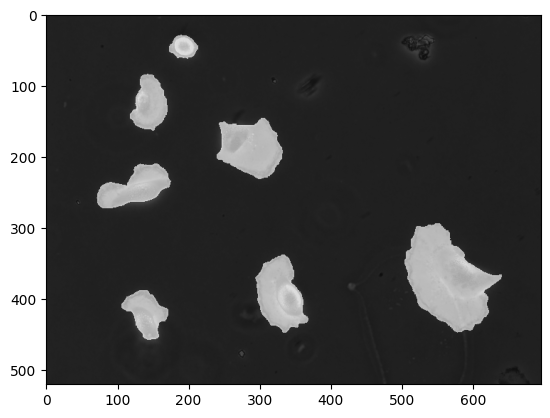

In [ ]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [ ]:
train_images.shape

(115, 520, 696)

In [ ]:
train_masks.shape

(115, 520, 696)

In [ ]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [ ]:
x_train.shape

(115, 520, 696, 2)

In [ ]:
x_train[0,:,:,0].max()

0.7254901960784313

In [ ]:
len(x_train)

115

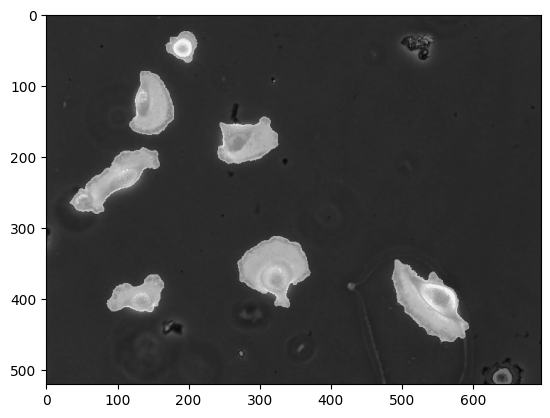

In [ ]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [ ]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

Este tipo de red de segmentación utiliza dilation rate para aumentar el campo receptivo sin aumentar la cantidad de parámetros entrenables y sin perder resolución espacial. El parámetro de dilation rate se puede pensar como la distancia entre los pixeles que se toman en cuenta para calcular el valor de salida de la neurona. En el caso de dilation rate = 1, se toman los pixeles vecinos, como en una convolución normal. En el caso de dilation rate = 2, se toman los pixeles que están a una distancia de 2 pixeles, y así sucesivamente.

In [ ]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

In [ ]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

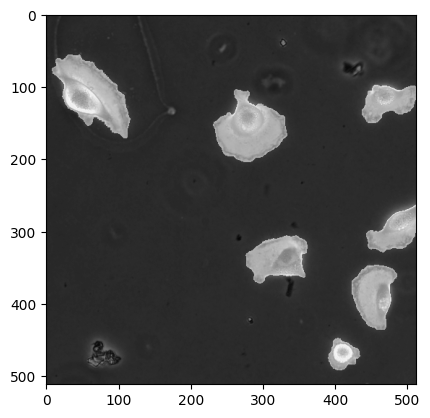

In [ ]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = False


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [ ]:
red_falopa = get_red_seg()

In [ ]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [ ]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
len(x_val)

115

In [ ]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 68s 2s/step - loss: 0.6555 - val_loss: 0.5519
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.4634 - val_loss: 0.1903
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.3657 - val_loss: 0.1831
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.3365 - val_loss: 0.2186
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.3385 - val_loss: 0.1968
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.3320 - val_loss: 0.1993
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 0.3315 - val_loss: 0.1895
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 0.3177 - val_loss: 0.1981
Epoch 9/100
8/8 [==============================] - 9s 1s/step - loss: 0.3119 - val_loss: 0.1807
Epoch 10/100
8/8 [==============================] - 8s 1s/step - loss: 0.3109 - val_loss: 0.1838
Epoch 11/100
8/8 [====================

In [ ]:
pred = red_falopa(x_val[0:10,:,:,0])
pred.shape

TensorShape([10, 520, 696, 1])

In [ ]:
pred.numpy().max()

0.99899167

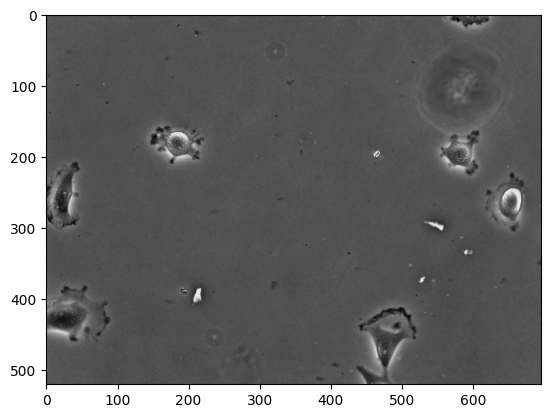

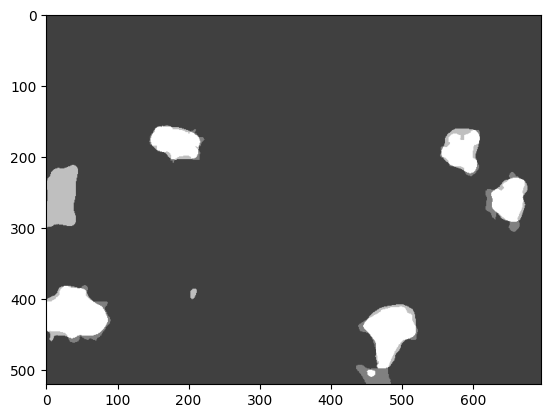

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

In [ ]:
x_val[0,:,:,1].shape

(520, 696)

In [ ]:
x_val[0,:,:,1].dtype

dtype('float64')

In [ ]:
pred[0,:,:,0].shape

TensorShape([520, 696])

In [ ]:
pred[0,:,:,0].dtype

tf.float32

In [ ]:
pred = np.array(pred, dtype='float64')

In [ ]:
pred[0,:,:,0].dtype

dtype('float64')

In [ ]:
dice = []
for i in range(10):
    dice += [dice_coef(x_val[i,:,:,1], pred[i,:,:,0], smooth=1e-6)]
np.array(dice).mean()

0.745326737908276

# Armo Red U-Net

La red U-Net es una red convolucional que tiene una arquitectura simétrica, con una parte descendente y una parte ascendente. La parte descendente es similar a la de una red convolucional normal, con capas convolucionales y pooling. La parte ascendente es similar a la de una red convolucional inversa, con capas de upsampling y convoluciones. La parte ascendente tiene conexiones con la parte descendente, de manera que se pueden utilizar las características aprendidas en la parte descendente para reconstruir la imagen.

En este caso se utiliza para realizar la segmentación de las células, de manera que la parte descendente aprende a detectar las características de las células, y la parte ascendente utiliza esas características para reconstruir la imagen segmentada.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

1. 'conv_block': Esta función define un bloque de convolución que consta de dos capas convolucionales seguidas de capas de activación y de batch normalization. Se puede aplicar una capa de dropout opcionalmente y, finalmente, concatenar la entrada original con la salida del bloque si se especifica el parámetro res.

2. 'level_block': Esta función define un bloque de nivel que representa una etapa en la arquitectura U-Net. Toma como entrada una capa y realiza varias operaciones a continuación. Primero, agrega un bloque de convolución utilizando la función 'conv_block'. Luego agrega una capa max pooling y llama recursivamente a 'level_block' hasta alcanzar la profundida especificada en 'depth'. Si se especifica 'up=True', agrega una capa de up sampling seguido de una convolución para aumentar la resolución de la capa antes de concatenarla con la capa de nivel superior. Al final, se aplica otro bloque de convolución utilizando 'conv_block'.

3. 'UNet': Esta función define la arquitectura completa de U-Net utilizando las anteriores. Toma como entrada el tamaño de la imagen de entrada y otros parámetros relacionados con la construcción de la red. Utiliza la función 'level_block' para realizar la codificación/decodificación de la imagen. A la salida de la red se añade una capa convolucional con función de activación sigmoide para producir la máscara de segmentación de píxeles.

In [ ]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [ ]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 50s 3s/step - loss: 0.6634 - val_loss: 0.6133
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.5765 - val_loss: 0.3876
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 0.3987 - val_loss: 0.1941
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 0.3621 - val_loss: 0.2558
Epoch 5/100
8/8 [==============================] - 14s 2s/step - loss: 0.3575 - val_loss: 0.2001
Epoch 6/100
8/8 [==============================] - 12s 2s/step - loss: 0.3438 - val_loss: 0.2199
Epoch 7/100
8/8 [==============================] - 12s 1s/step - loss: 0.3418 - val_loss: 0.1980
Epoch 8/100
8/8 [==============================] - 12s 1s/step - loss: 0.3446 - val_loss: 0.2054
Epoch 9/100
8/8 [==============================] - 14s 2s/step - loss: 0.3262 - val_loss: 0.1840
Epoch 10/100
8/8 [==============================] - 14s 2s/step - loss: 0.3092 - val_loss: 0.1873
Epoch 11/100
8/8 [===========

In [ ]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_12[0][0]']              
                                )                                                             

In [ ]:
aux = preproc_unet_val(x_val[0:10,:,:,:])
pred_unet = red_unet(aux[0:10,:,:,0])
pred_unet.shape

TensorShape([10, 512, 512, 1])

In [ ]:
pred_unet.numpy().max()

0.99982077

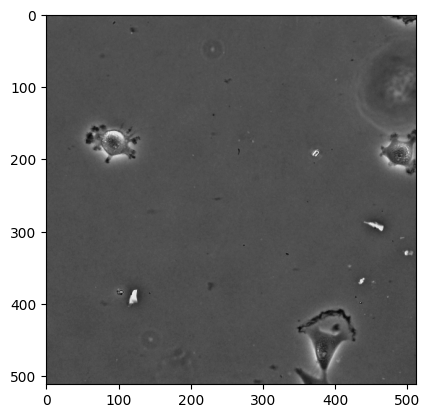

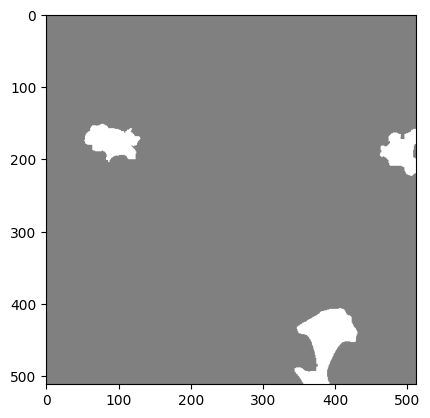

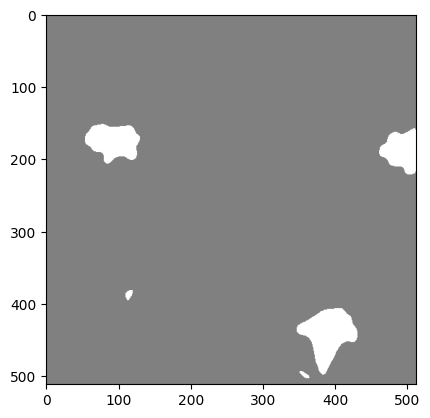

In [ ]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred_unet[0,:,:,0]>0.7, cmap="gray", alpha = 0.5)
plt.show()

In [ ]:
aux[0,:,:,1].shape

TensorShape([512, 512])

In [ ]:
aux[0,:,:,1].dtype

tf.float32

In [ ]:
aux = np.array(aux, dtype='float64')

In [ ]:
pred_unet[0,:,:,0].dtype

tf.float32

In [ ]:
pred_unet[0,:,:,0].shape

TensorShape([512, 512])

In [ ]:
pred_unet[0,:,:,0].dtype

tf.float32

In [ ]:
pred_unet = np.array(pred_unet, dtype='float64')

In [ ]:
pred_unet[0,:,:,0].dtype

dtype('float64')

In [ ]:
dice = []
for i in range(10):
    dice += [dice_coef(aux[i,:,:,1], pred_unet[i,:,:,0], smooth=1e-6)]
np.array(dice).mean()

0.8190201680303721